In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
pd.set_option('display.max_rows', 500)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import time
import math
pd.options.mode.copy_on_write = True 
import datetime

In [2]:
df_lane = pd.read_excel(r'C:\Users\C385490\OneDrive - Anheuser-Busch InBev\Projects\Shipment_Prediction\Data\Lane_shipment_data.xlsx')
df_lane.head()

,date,week,year,month,Lane,shipment
0,2021-12-20,51,2021,12,DE02_29080846,1
1,2022-03-21,12,2022,3,DE02_29080846,1
2,2020-01-06,2,2020,1,DE02_29080846,0
3,2020-01-13,3,2020,1,DE02_29080846,0
4,2020-01-20,4,2020,1,DE02_29080846,0


In [3]:
df_holiday = pd.read_excel(r'C:\Users\C385490\OneDrive - Anheuser-Busch InBev\Projects\Shipment_Prediction\Data\holiday sheet.xlsx')
df_holiday.head()

,year,week,Holiday Flag
0,2020,1,1
1,2020,15,1
2,2020,17,1
3,2020,18,1
4,2020,21,1


In [4]:
df_holiday.dtypes

year            int64
week            int64
Holiday Flag    int64
dtype: object

# Data Preprocessing

In [5]:

def top20Lane_selection(final_data):
    week_count = pd.DataFrame(columns = ['Lane','Count'])
    lan = []
    count = []

    top_lanes= final_data[(final_data['year']==2023) & final_data['shipment']!=0]
    for lane in top_lanes['Lane'].unique():
        cnt = top_lanes[top_lanes['Lane']==lane]['date'].nunique()
        lan.append(lane)
        count.append(cnt)

    week_count['Lane'] = lan
    week_count['Count'] = count

    lanes_week_wise = list(week_count.sort_values('Count', ascending = False)[:30]['Lane'].unique())

    top20_Lanes = final_data[final_data['Lane'].isin(lanes_week_wise)].reset_index(drop=True)
    top20_Lanes = top20_Lanes.groupby(['Lane','year'])['shipment'].sum().reset_index()
    top20_Lanes = top20_Lanes[top20_Lanes['year']==2023]
    top20_Lanes = list(top20_Lanes.sort_values('shipment', ascending = False)[:20]['Lane'].unique())

    top20_df = final_data[final_data['Lane'].isin(top20_Lanes)].reset_index(drop=True)


    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Fit and transform the categorical column
    encoded_values = label_encoder.fit_transform(top20_df['Lane'])

    ## Create a dictionary to store the mapping of original labels to encoded values
    label_mapping = {label: int(encoded_value) for label, encoded_value in zip(label_encoder.classes_, encoded_values)}

    # Save the label mapping as JSON file
    with open('lane_enocoded_labels.json', 'w') as json_file:
        json.dump(label_mapping, json_file)

    # read the label mapping JSON file
    with open('lane_enocoded_labels.json', 'r') as json_file:
        label_mapping = json.load(json_file)

    
    top20_df['Encoded_Lane'] = top20_df['Lane'].map(label_mapping)

    return top20_df


    

In [6]:
def data_manipulation_selection(df_lane,df_holiday):
    final_data = pd.merge(df_lane, df_holiday, on=['year', 'week'], how='left')
    #fill Nan value with 0 in holiday_flag
    final_data['Holiday Flag'] = final_data['Holiday Flag'].fillna(0)
    final_data['Holiday Flag'] = final_data['Holiday Flag'].astype(np.int64)


    final_data['Quarter'] = final_data['date'].dt.quarter
    final_data['Quarter'] = final_data['Quarter'].astype(np.int64)

    top20_df = top20Lane_selection(final_data)

    return final_data, top20_df

    

In [7]:
final_data, top20_df = data_manipulation_selection(df_lane,df_holiday)
top20_df.shape

(4160, 9)

In [8]:
def data_preprocessing(df):

    # 1st Lag features
    df['Previous Week Shipment'] = df['shipment'].shift(1)
    df['Previous Year Shipment'] = df.groupby(['Lane'])['shipment'].shift(52)

    # 2nd Lag features
    df['Previous 2Week Shipment'] = df['shipment'].shift(2)
    

    #Filling Nan values in 1st Lag Feature

    df['Previous Year Shipment'] = df['Previous Year Shipment'].interpolate()
    df['Previous Year Shipment'] = df['Previous Year Shipment'].fillna(0)
    df['Previous Week Shipment'] = df['Previous Week Shipment'].fillna(0)
    df['Previous 2Week Shipment'] = df['Previous 2Week Shipment'].fillna(0)
    
    
    # Historical trends
    #df['Moving Average Shipment'] = df.groupby(['Lane'])['shipment'].rolling(window=4).mean().reset_index(drop=True)
    #df['Moving Average Shipment'] = df['Moving Average Shipment'].fillna(0) 

    # Convert created features to integer
    df['Previous Week Shipment'] = df['Previous Week Shipment'].astype(np.int64)
    df['Previous 2Week Shipment'] = df['Previous 2Week Shipment'].astype(np.int64)
    df['Previous Year Shipment'] = df['Previous Year Shipment'].astype(np.int64)
    #df['Moving Average Shipment'] = df['Moving Average Shipment'].astype(np.int64)

    # X = df.drop(columns = ['date', 'year', 'Lane',  'Quarter','shipment', 'shipment_transformed'])
    # y = df['shipment_transformed']

    return df
    
    

In [9]:
from scipy.special import boxcox, inv_boxcox

def data_tain_test_split(top20_df):

    # Box-cox transform
    top20_df['shipment_transformed']= np.log1p(top20_df['shipment'])
    
    top20_df = data_preprocessing(top20_df)
    

    #filter latest 8 weeks for testing the model
    test = top20_df[(top20_df['year'] == 2023) & (top20_df['week'] >= 45)].reset_index(drop=True)
    test.loc[1:,'Previous Week Shipment'] = np.nan 
    test.loc[52:,'Previous Year Shipment'] = np.nan
    #test.loc[1:,'Moving Average Shipment'] = np.nan
    test.loc[2:,'Previous 2Week Shipment'] = np.nan
    #train dataset except last 8 weeks
    train = top20_df.drop(index = test.index.tolist()).reset_index(drop=True)
    

    return train, test

In [10]:
train, test = data_tain_test_split(top20_df)
print("train_data_shape: ",train.shape)
print("test_data_shape: ",test.shape)

train_data_shape:  (4000, 13)
test_data_shape:  (160, 13)


In [11]:
X_train = train.drop(columns = ['date', 'year', 'Lane',  'Quarter','shipment', 'shipment_transformed'])
y_train  = train['shipment_transformed']

X_test = test.drop(columns = ['date', 'year', 'Lane',  'Quarter','shipment', 'shipment_transformed'])
y_test  = test['shipment_transformed']

(array([ 572.,    0., 1426.,  868.,  448.,  370.,  222.,   59.,   29.,
           6.]),
 array([0.        , 0.32188758, 0.64377516, 0.96566275, 1.28755033,
        1.60943791, 1.93132549, 2.25321308, 2.57510066, 2.89698824,
        3.21887582]),
 <BarContainer object of 10 artists>)

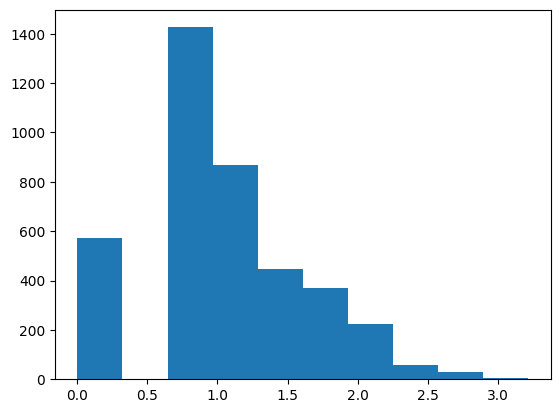

In [12]:
import matplotlib.pyplot as plt
plt.hist(y_train)

# Model Building

In [13]:
# Sample function to calculate WAPE
def weighted_absolute_percentage_error(y_true, y_pred):
    total_weight = sum(y_true)
    
    # Check if total_weight is zero to avoid division by zero
    if total_weight == 0:
        return None  # Return None to indicate no shipments
    
    absolute_errors = abs(y_true - y_pred)
    weighted_absolute_errors = absolute_errors * y_true
    wape = sum(weighted_absolute_errors) / total_weight * 100
    return wape

In [15]:
import lightgbm as lgb
model1 = lgb.LGBMRegressor()
model1.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 131
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 7
[LightGBM] [Info] Start training from score 0.969826


LGBMRegressor()

# Prediction

In [16]:
def predict_evaluate(model, X_test, y_test):

    y_pred = []
    pred1 = model.predict(X_test.iloc[0:1,:].fillna(0))
    y_pred.append(list(pred1)[0])

    for i, row in X_test.iloc[1:,:].iterrows():
        if not np.isnan(row['Previous Week Shipment']):
            pass
        else:
            X_test.loc[i, "Previous Week Shipment"] = y_pred[i-1]

        if not np.isnan(row['Previous Year Shipment']):
            pass
        else:
            X_test.loc[i, "Previous Year Shipment"] = y_pred[i-52]

        if not np.isnan(row['Previous 2Week Shipment']):
            pass
        else:
            X_test.loc[i, "Previous 2Week Shipment"] = y_pred[i-2]

        pred1 = model.predict(X_test.iloc[i:i+1,:].fillna(0))
        y_pred.append(list(pred1)[0])



    
       
    # Calculate WAPE score
    wape = weighted_absolute_percentage_error(y_test, y_pred)


    test['Predicted_shipment'] = [round(np.expm1(x)) for x in y_pred]
    #test['Predicted_shipment'] = [round(x) for x in y_pred]
    
    
    return test, wape

In [17]:
predicted_df, wape = predict_evaluate(model1, X_test, y_test)
wape

50.26361121805286

In [18]:
predicted_df.to_csv('predicted_shipment_V13.csv', index = False)

(array([146.,   0.,   0.,   8.,   0.,   0.,   3.,   0.,   0.,   3.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

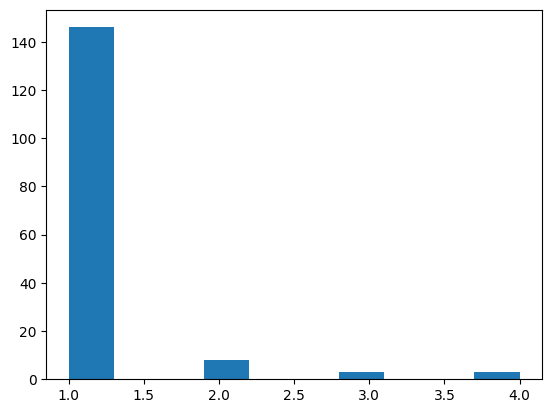

In [19]:
plt.hist(predicted_df['Predicted_shipment'])

In [20]:
predicted_df['Predicted_shipment'].unique()

array([1, 4, 2, 3], dtype=int64)

In [21]:
predicted_df['shipment'].unique()

array([ 4,  3,  6,  2,  5,  7,  1,  9,  0,  8, 12], dtype=int64)

In [22]:
#predicted_df[predicted_df['Predicted_shipment']>2][['shipment', 'Predicted_shipment']]
predicted_df[['shipment', 'Predicted_shipment']].head(10)

,shipment,Predicted_shipment
0,4,1
1,3,1
2,6,1
3,2,1
4,5,1
5,3,1
6,7,4
7,2,1
8,3,1
9,6,1


In [23]:
import joblib
# Save the model to a file
joblib.dump(model1, 'lgb_model_V13.joblib')

['Xgb_model_V13.joblib']

In [24]:
100 - wape

49.73638878194714